In [1]:
import torch
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2 

import sys

sys.path.append("py")
from capcha_net import CapchaNet

In [2]:
def load_data(path):
    X = []
    y = []
    failed = []
    letter_arr = list(map(chr,[48, 49 ,50 ,51 ,52 ,53 ,54 ,55, 56 ,57 ,65, 
                               66 ,67, 68, 69, 70, 71, 76 ,79 ,80, 81 ,83]))
    for img_path in glob.glob(path):
    
        img = plt.imread(img_path)
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))

        if "test" in img_path:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][5:].upper()))
        elif "train" in img_path:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][6:].upper()))
        else:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][9:].upper()))
            #print(img_path)
        if len(img_name)!=5:
            failed.append(img)
            print(img_path)
            continue
        
        X.append(magic(img[3:-7, 3:-7]))
        y.append(list(img_name))
        
    return np.asarray(X), np.asarray(y),failed

def magic(img):
    img = img.copy()
    img[:,:,0]+=0.01
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)*255
    img_hsv = img_hsv.astype('uint8')
    th2 = cv2.adaptiveThreshold(img_hsv[:,:,1],255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    ksize = (4, 4) 
    th2 = cv2.blur(th2, ksize) 
   # th2 = cv2.adaptiveThreshold(th2,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
   # th2 = th2.astype(int)
    return th2/255

def from_digits(list_digits):
    letter_arr = list(map(chr,[48, 49 ,50 ,51 ,52 ,53 ,54 ,55, 56 ,57 ,65, 
                               66 ,67, 68, 69, 70, 71, 76 ,79 ,80, 81 ,83]))
    chrs = list(map(lambda x:letter_arr[x], list_digits))
    return "".join(chrs)

def per_accuracy(data, answer):
    s = np.sum((data.argmax(dim=1) == answer).detach().numpy(),axis =1)
    count_of_excellent = np.where(s == 5)

    return len(count_of_excellent[0])/len(s)


In [3]:
X_train, y_train, f = load_data("train//*")
X_test, y_test, f = load_data("test//*")


X_train = X_train.reshape(-1,1,X_train[0].shape[0],X_train[0].shape[1])
X_test = X_test.reshape(-1,1,X_test[0].shape[0],X_test[0].shape[1])

X_test = torch.from_numpy(X_test).float()
X_train = torch.from_numpy(X_train).float()

y_test = torch.from_numpy(y_test.astype(np.float))
y_train = torch.from_numpy(y_train.astype(np.float))


train\5A4B.png
train\D780.png
train\ec5f.png
test\27AA.png
test\9B07.png
test\B20EB0.png
test\E1AEEF.png
test\E93E.png


In [4]:
model = CapchaNet()
model.load_state_dict(torch.load("model/detector_capchanet_v1_63.pth"))
model.eval()


CapchaNet(
  (conv1): Conv2d(1, 5, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=5, stride=2, padding=0)
  (conv2): Conv2d(5, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2520, out_features=1425, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=1425, out_features=120, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (act5): Tanh()
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=84, out_features=22, bias=True)
)

Train per-sample accuracy:  1.0


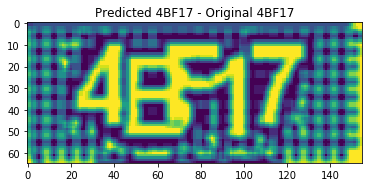

In [5]:
train_preds = model.forward(X_train)
train_preds = train_preds.reshape(-1,22,5)
accuracy = (train_preds.argmax(dim=1) == y_train).float().mean()
print("Train per-sample accuracy: ", per_accuracy(train_preds, y_train))

i = 120
predicted = from_digits(list(train_preds.argmax(dim=1)[i].detach().numpy()))
original = from_digits(list(y_train.detach().numpy()[i].astype(int)))

plt.title("Predicted %s - Original %s"%(predicted,original))
plt.imshow(np.asarray(X_train[i]).reshape(X_train[i].shape[-2:]));

Accuracy:  0.9094936847686768
Test per-sample accuracy:  0.6360759493670886


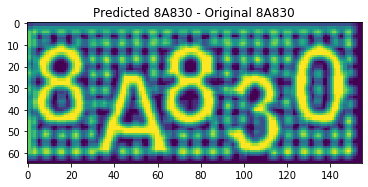

In [6]:
test_preds = model.forward(X_test)
test_preds = test_preds.reshape(-1,22,5)
accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
print("Accuracy: ", accuracy.item())
print("Test per-sample accuracy: ", per_accuracy(test_preds, y_test))

i = 120
predicted = from_digits(list(test_preds.argmax(dim=1)[i].detach().numpy()))
original = from_digits(list(y_test.detach().numpy()[i].astype(int)))

plt.title("Predicted %s - Original %s"%(predicted,original))
plt.imshow(np.asarray(X_test[i]).reshape(X_test[i].shape[-2:]));